# Analyse du Taux d'Attrition - HumanForYou

## Projet d'Intelligence Artificielle

**Contexte** : L'entreprise pharmaceutique HumanForYou (basée en Inde, ~4000 employés) connaît un taux de rotation d'environ 15% par an. La direction souhaite identifier les facteurs influençant ce taux et proposer des pistes d'amélioration pour fidéliser les employés.

**Objectifs** :
1. Explorer et analyser les données des employés
2. Identifier les facteurs clés d'attrition
3. Construire des modèles prédictifs
4. Évaluer et comparer les performances
5. Proposer des recommandations

---

## 1. Configuration et Imports

In [1]:
#!pip install xgboost
#!pip install shap
#!pip install numpy
#!pip install scikit-learn
#!pip install matplotlib

In [2]:
# Configuration des warnings
import warnings
warnings.filterwarnings('ignore')

# Imports de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Configuration de l'affichage
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Ajouter le chemin du projet au PYTHONPATH
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(" Configuration de base terminée")

✅ Configuration de base terminée


In [3]:
# Imports ML
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
)

# XGBoost (optionnel)
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print(" XGBoost disponible")
except ImportError:
    XGBOOST_AVAILABLE = False
    print(" XGBoost non disponible (installez avec: pip install xgboost)")

# SHAP pour l'interprétabilité (optionnel)
try:
    import shap
    SHAP_AVAILABLE = True
    print(" SHAP disponible")
except ImportError:
    SHAP_AVAILABLE = False
    print(" SHAP non disponible (installez avec: pip install shap)")

✅ XGBoost disponible
✅ SHAP disponible


---
## 2. Chargement des Données

In [31]:
# Définir le chemin vers les données
DATA_PATH = '../data'

# Vérifier les fichiers disponibles
print("Fichiers de données disponibles :")
for f in os.listdir(DATA_PATH):
    filepath = os.path.join(DATA_PATH, f)
    if os.path.isfile(filepath):
        size = os.path.getsize(filepath)
        print(f"  - {f} ({size:,} bytes)")

Fichiers de données disponibles :
  - .gitkeep (305 bytes)
  - employee_survey_data.csv (463 bytes)
  - general_data.csv (549,994 bytes)
  - in_out_time.zip (9,393,990 bytes)
  - manager_survey_data.csv (356 bytes)


In [5]:
# Charger les données disponibles
employee_survey = None
manager_survey = None
general_data = None

# Employee Survey Data
try:
    employee_survey = pd.read_csv(os.path.join(DATA_PATH, 'employee_survey_data.csv'), na_values=['NA', 'na', 'N/A', ''])
    print(f" employee_survey_data.csv chargé: {employee_survey.shape}")
except FileNotFoundError:
    print(" employee_survey_data.csv non trouvé")

# Manager Survey Data
try:
    manager_survey = pd.read_csv(os.path.join(DATA_PATH, 'manager_survey_data.csv'))
    print(f" manager_survey_data.csv chargé: {manager_survey.shape}")
except FileNotFoundError:
    print(" manager_survey_data.csv non trouvé")

# General Data (optionnel - fichier trop volumineux)
try:
    general_data = pd.read_csv(os.path.join(DATA_PATH, 'general_data.csv'))
    print(f" general_data.csv chargé: {general_data.shape}")
    FULL_DATASET = True
except FileNotFoundError:
    print(" general_data.csv non trouvé (fichier à ajouter manuellement)")
    FULL_DATASET = False
    print("   Le notebook fonctionnera avec les données partielles disponibles")

✅ employee_survey_data.csv chargé: (40, 4)
✅ manager_survey_data.csv chargé: (40, 3)
✅ general_data.csv chargé: (4410, 24)


In [6]:
# Aperçu des données chargées
if employee_survey is not None:
    print("\n Employee Survey Data :")
    display(employee_survey.head())
    print(f"\nColonnes: {list(employee_survey.columns)}")
    print(f"Valeurs manquantes:\n{employee_survey.isnull().sum()}")


📊 Employee Survey Data :


,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,NaN,1.0
3,4,4.0,4.0,3.0
4,5,4.0,4.0,3.0



Colonnes: ['EmployeeID', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
Valeurs manquantes:
EmployeeID                 0
EnvironmentSatisfaction    1
JobSatisfaction            2
WorkLifeBalance            1
dtype: int64


In [7]:
if manager_survey is not None:
    print("\n📊 Manager Survey Data :")
    display(manager_survey.head())
    print(f"\nColonnes: {list(manager_survey.columns)}")


📊 Manager Survey Data :


,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,3,3
4,5,3,3



Colonnes: ['EmployeeID', 'JobInvolvement', 'PerformanceRating']


In [8]:
if general_data is not None:
    print("\n General Data :")
    display(general_data.head())
    print(f"\nColonnes: {list(general_data.columns)}")
    print(f"\nVariable cible (Attrition):")
    print(general_data['Attrition'].value_counts())


📊 General Data :


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4



Colonnes: ['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Variable cible (Attrition):
Attrition
No     3699
Yes     711
Name: count, dtype: int64


### Fusion des Datasets

In [9]:
# Fusionner les données disponibles
if FULL_DATASET and general_data is not None:
    # Standardiser les noms de colonnes
    if 'EmployeeId' in general_data.columns:
        general_data.rename(columns={'EmployeeId': 'EmployeeID'}, inplace=True)
    
    df = general_data.copy()
    
    if employee_survey is not None:
        df = df.merge(employee_survey, on='EmployeeID', how='left')
        print(" Fusionné avec employee_survey")
    
    if manager_survey is not None:
        df = df.merge(manager_survey, on='EmployeeID', how='left')
        print(" Fusionné avec manager_survey")
    
    print(f"\n Dataset fusionné: {df.shape[0]} lignes × {df.shape[1]} colonnes")
else:
    # Travailler avec les données partielles
    if employee_survey is not None and manager_survey is not None:
        df = employee_survey.merge(manager_survey, on='EmployeeID', how='outer')
        print(f"\n Dataset partiel (surveys uniquement): {df.shape[0]} lignes × {df.shape[1]} colonnes")
        print("\n Note: Sans general_data.csv, la variable cible (Attrition) n'est pas disponible.")
        print("   Ajoutez le fichier general_data.csv pour une analyse complète.")
    else:
        df = None
        print(" Pas assez de données pour créer un dataset")

✅ Fusionné avec employee_survey
✅ Fusionné avec manager_survey

📊 Dataset fusionné: 4410 lignes × 29 colonnes


---
## 3. Analyse Exploratoire (EDA)

In [10]:
if df is not None:
    print("📋 Informations générales sur le dataset :")
    print(f"\nDimensions: {df.shape[0]} lignes × {df.shape[1]} colonnes")
    print(f"\nTypes de données:")
    print(df.dtypes.value_counts())
    print(f"\nMémoire utilisée: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

📋 Informations générales sur le dataset :

Dimensions: 4410 lignes × 29 colonnes

Types de données:
int64      14
object      8
float64     7
Name: count, dtype: int64

Mémoire utilisée: 2.93 MB


In [11]:
if df is not None:
    print("\n📊 Statistiques descriptives (variables numériques) :")
    display(df.describe().round(2))


📊 Statistiques descriptives (variables numériques) :


,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410.00,4410.00,4410.00,4410.0,4410.00,4410.00,4410.00,4391.00,4410.00,4410.0,4410.00,4401.00,4410.00,4410.00,4410.00,4410.00,39.00,38.00,39.00,40.00,40.00
mean,36.92,9.19,2.91,1.0,2205.50,2.06,65029.31,2.69,15.21,8.0,0.79,11.28,2.80,7.01,2.19,4.12,3.03,2.97,2.77,2.98,3.22
std,9.13,8.11,1.02,0.0,1273.20,1.11,47068.89,2.50,3.66,0.0,0.85,7.78,1.29,6.13,3.22,3.57,1.04,1.10,0.58,0.48,0.42
min,18.00,1.00,1.00,1.0,1.00,1.00,10090.00,0.00,11.00,8.0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,2.00,3.00
25%,30.00,2.00,2.00,1.0,1103.25,1.00,29110.00,1.00,12.00,8.0,0.00,6.00,2.00,3.00,0.00,2.00,2.50,2.00,3.00,3.00,3.00
50%,36.00,7.00,3.00,1.0,2205.50,2.00,49190.00,2.00,14.00,8.0,1.00,10.00,3.00,5.00,1.00,3.00,3.00,3.00,3.00,3.00,3.00
75%,43.00,14.00,4.00,1.0,3307.75,3.00,83800.00,4.00,18.00,8.0,1.00,15.00,3.00,9.00,3.00,7.00,4.00,4.00,3.00,3.00,3.00
max,60.00,29.00,5.00,1.0,4410.00,5.00,199990.00,9.00,25.00,8.0,3.00,40.00,6.00,40.00,15.00,17.00,4.00,4.00,4.00,4.00,4.00


In [12]:
if df is not None:
    print("\n🔍 Valeurs manquantes :")
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    if len(missing) > 0:
        for col, count in missing.items():
            pct = count / len(df) * 100
            print(f"  • {col}: {count} ({pct:.1f}%)")
    else:
        print("  Aucune valeur manquante !")


🔍 Valeurs manquantes :
  • JobSatisfaction: 4372 (99.1%)
  • EnvironmentSatisfaction: 4371 (99.1%)
  • WorkLifeBalance: 4371 (99.1%)
  • JobInvolvement: 4370 (99.1%)
  • PerformanceRating: 4370 (99.1%)
  • NumCompaniesWorked: 19 (0.4%)
  • TotalWorkingYears: 9 (0.2%)


### Distribution de la Variable Cible


📊 Distribution de l'Attrition :
Attrition
No     3699
Yes     711
Name: count, dtype: int64

Taux d'attrition: 16.1%


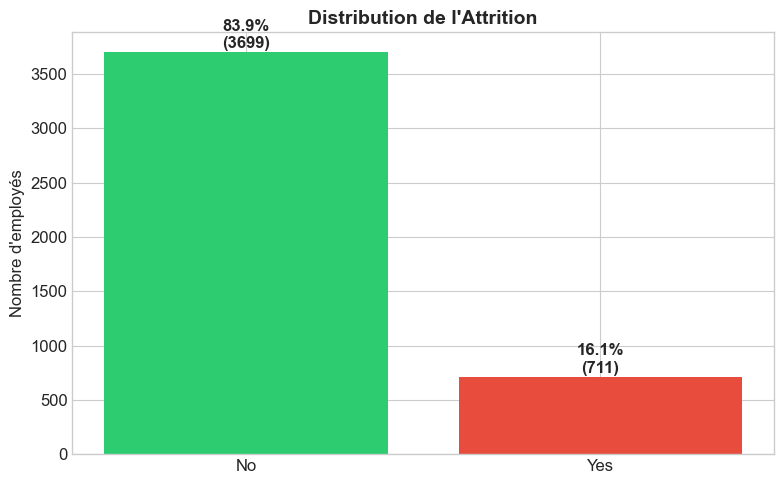

In [13]:
if df is not None and 'Attrition' in df.columns:
    print("\n📊 Distribution de l'Attrition :")
    print(df['Attrition'].value_counts())
    print(f"\nTaux d'attrition: {(df['Attrition'] == 'Yes').mean() * 100:.1f}%")
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = ['#2ecc71', '#e74c3c']
    counts = df['Attrition'].value_counts()
    bars = ax.bar(counts.index, counts.values, color=colors)
    
    for bar, count in zip(bars, counts.values):
        pct = count / len(df) * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                f'{pct:.1f}%\n({count})', ha='center', va='bottom', fontweight='bold')
    
    ax.set_title('Distribution de l\'Attrition', fontsize=14, fontweight='bold')
    ax.set_ylabel('Nombre d\'employés')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Variable Attrition non disponible")
    print("   Ajoutez le fichier general_data.csv pour accéder à cette variable.")

### Distribution des Variables Numériques

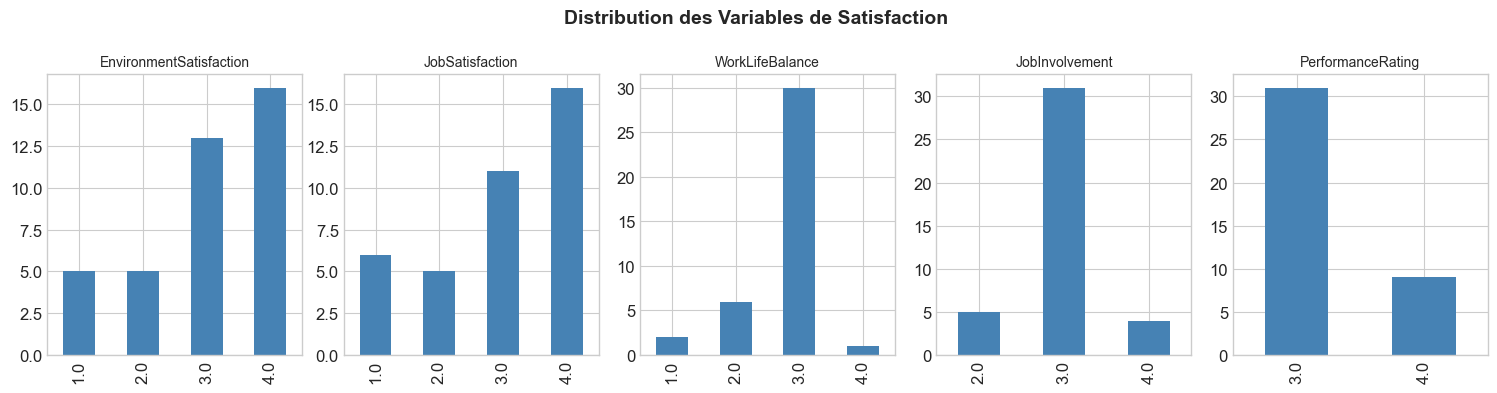

In [14]:
if df is not None:
    # Variables de satisfaction (surveys)
    survey_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 
                   'JobInvolvement', 'PerformanceRating']
    available_cols = [c for c in survey_cols if c in df.columns]
    
    if available_cols:
        fig, axes = plt.subplots(1, len(available_cols), figsize=(15, 4))
        if len(available_cols) == 1:
            axes = [axes]
        
        for ax, col in zip(axes, available_cols):
            df[col].value_counts().sort_index().plot(kind='bar', ax=ax, color='steelblue')
            ax.set_title(col, fontsize=10)
            ax.set_xlabel('')
        
        plt.suptitle('Distribution des Variables de Satisfaction', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

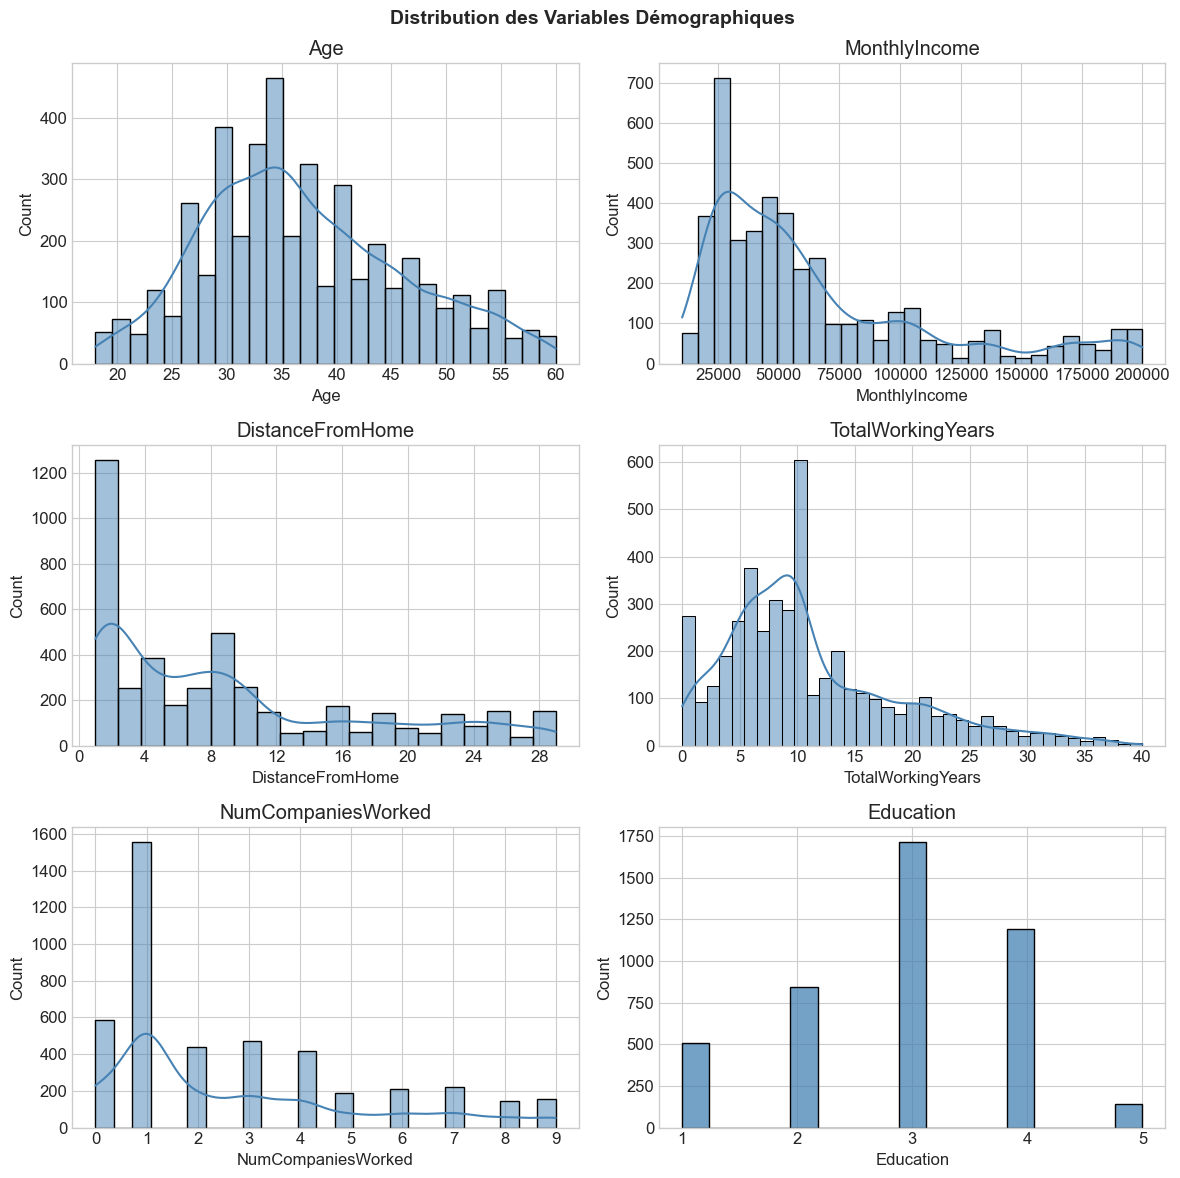

In [41]:
if df is not None and FULL_DATASET:
    # Variables démographiques
    demo_cols = ['Age', 'MonthlyIncome', 'DistanceFromHome', 'TotalWorkingYears', 'NumCompaniesWorked', 'Education']
    available_demo = [c for c in demo_cols if c in df.columns]
    
    if available_demo:
        n_vars = len(available_demo)
        n_cols = 2  # Nombre de colonnes dans la grille (fixe)
        n_rows = int((n_vars + n_cols - 1) // n_cols)  # Division entière arrondie vers le haut
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
        axes = axes.flatten()
        
        for i, col in enumerate(available_demo):
            # Pas de ligne KDE pour Education, mais oui pour les autres
            show_kde = (col != 'Education')
            sns.histplot(df[col], ax=axes[i], kde=show_kde, color='steelblue')
            axes[i].set_title(col)
            # Forcer les valeurs entières sur l'axe x
            axes[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        # Cacher les axes vides
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        
        plt.suptitle('Distribution des Variables Démographiques', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

### Matrice de Corrélation

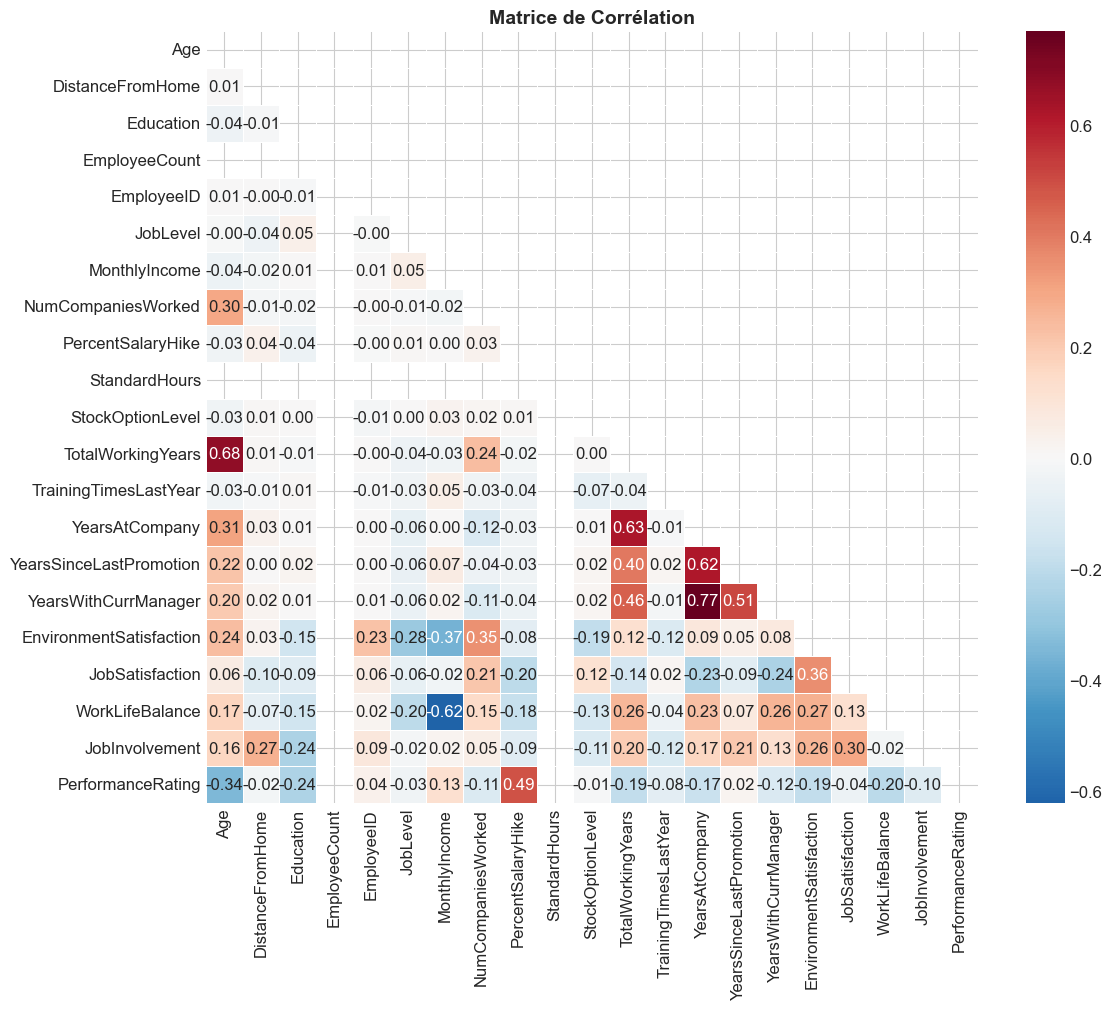

In [ ]:
if df is not None:
    # Corrélation entre les variables numériques
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Supprimer les colonnes avec variance nulle ou toutes NaN
    numeric_df = numeric_df.loc[:, numeric_df.std() > 0]
    numeric_df = numeric_df.dropna(axis=1, how='all')
    
    if len(numeric_df.columns) > 1:
        plt.figure(figsize=(12, 10))
        corr = numeric_df.corr()
        
        # Supprimer les lignes/colonnes entièrement vides dans la matrice de corrélation
        corr = corr.dropna(axis=0, how='all').dropna(axis=1, how='all')
        
        if not corr.empty:
            mask = np.triu(np.ones_like(corr, dtype=bool))
            
            sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
                        center=0, square=True, linewidths=0.5)
            plt.title('Matrice de Corrélation', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ Pas de données valides pour la matrice de corrélation")
    else:
        print("⚠️ Pas assez de colonnes numériques pour calculer les corrélations")

---
## 4. Prétraitement des Données

In [17]:
if df is not None:
    df_processed = df.copy()
    
    # 1. Gestion des valeurs manquantes
    print(" Traitement des valeurs manquantes...")
    
    for col in df_processed.select_dtypes(include=[np.number]).columns:
        if df_processed[col].isnull().sum() > 0:
            median_val = df_processed[col].median()
            df_processed[col].fillna(median_val, inplace=True)
            print(f"  • {col}: valeurs manquantes remplacées par la médiane ({median_val})")
    
    for col in df_processed.select_dtypes(include=['object']).columns:
        if df_processed[col].isnull().sum() > 0:
            mode_val = df_processed[col].mode()[0]
            df_processed[col].fillna(mode_val, inplace=True)
            print(f"  • {col}: valeurs manquantes remplacées par le mode ({mode_val})")
    
    print(f"\n Valeurs manquantes restantes: {df_processed.isnull().sum().sum()}")

🔧 Traitement des valeurs manquantes...
  • NumCompaniesWorked: valeurs manquantes remplacées par la médiane (2.0)
  • TotalWorkingYears: valeurs manquantes remplacées par la médiane (10.0)
  • EnvironmentSatisfaction: valeurs manquantes remplacées par la médiane (3.0)
  • JobSatisfaction: valeurs manquantes remplacées par la médiane (3.0)
  • WorkLifeBalance: valeurs manquantes remplacées par la médiane (3.0)
  • JobInvolvement: valeurs manquantes remplacées par la médiane (3.0)
  • PerformanceRating: valeurs manquantes remplacées par la médiane (3.0)

✅ Valeurs manquantes restantes: 0


In [18]:
if df is not None and 'Attrition' in df_processed.columns:
    # 2. Encodage de la variable cible
    print("\n Encodage de la variable cible...")
    
    if df_processed['Attrition'].dtype == 'object':
        df_processed['Attrition'] = df_processed['Attrition'].map({'Yes': 1, 'No': 0})
        print(f"  • Attrition encodée: Yes=1, No=0")
    
    print(f"\n Distribution après encodage:")
    print(df_processed['Attrition'].value_counts())


🏷️ Encodage de la variable cible...
  • Attrition encodée: Yes=1, No=0

 Distribution après encodage:
Attrition
0    3699
1     711
Name: count, dtype: int64


In [19]:
if df is not None:
    # 3. Encodage des variables catégorielles
    print("\n Encodage des variables catégorielles...")
    
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    # Exclure les colonnes d'ID
    categorical_cols = [c for c in categorical_cols if 'ID' not in c.upper()]
    
    encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        encoders[col] = le
        print(f"  • {col}: {len(le.classes_)} classes encodées")
    
    print(f"\n {len(categorical_cols)} colonnes catégorielles encodées")


🏷️ Encodage des variables catégorielles...
  • BusinessTravel: 3 classes encodées
  • Department: 3 classes encodées
  • EducationField: 6 classes encodées
  • Gender: 2 classes encodées
  • JobRole: 9 classes encodées
  • MaritalStatus: 3 classes encodées
  • Over18: 1 classes encodées

✅ 7 colonnes catégorielles encodées


---
## 5. Feature Engineering

In [20]:
if df is not None and FULL_DATASET:
    print("🛠️ Création de features dérivées...")
    
    new_features = []
    
    # Ratio ancienneté
    if 'YearsAtCompany' in df_processed.columns and 'TotalWorkingYears' in df_processed.columns:
        df_processed['TenureRatio'] = df_processed['YearsAtCompany'] / (df_processed['TotalWorkingYears'] + 1)
        new_features.append('TenureRatio')
    
    # Stagnation de promotion
    if 'YearsSinceLastPromotion' in df_processed.columns and 'YearsAtCompany' in df_processed.columns:
        df_processed['PromotionStagnation'] = df_processed['YearsSinceLastPromotion'] / (df_processed['YearsAtCompany'] + 1)
        new_features.append('PromotionStagnation')
    
    # Score de satisfaction globale
    satisfaction_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
    available_sat = [c for c in satisfaction_cols if c in df_processed.columns]
    if available_sat:
        df_processed['OverallSatisfaction'] = df_processed[available_sat].mean(axis=1)
        new_features.append('OverallSatisfaction')
    
    # Revenu par année d'expérience
    if 'MonthlyIncome' in df_processed.columns and 'TotalWorkingYears' in df_processed.columns:
        df_processed['IncomePerYear'] = df_processed['MonthlyIncome'] / (df_processed['TotalWorkingYears'] + 1)
        new_features.append('IncomePerYear')
    
    print(f"\n✅ {len(new_features)} nouvelles features créées:")
    for f in new_features:
        print(f"  • {f}")
else:
    print(" Feature engineering limité sans le dataset complet")

🛠️ Création de features dérivées...

✅ 4 nouvelles features créées:
  • TenureRatio
  • PromotionStagnation
  • OverallSatisfaction
  • IncomePerYear


---
## 6. Préparation des Données pour le Modèle

In [21]:
if df is not None and 'Attrition' in df_processed.columns:
    print(" Préparation train/test split...")
    
    # Séparer features et target
    cols_to_drop = ['Attrition']
    if 'EmployeeID' in df_processed.columns:
        cols_to_drop.append('EmployeeID')
    if 'EmployeeId' in df_processed.columns:
        cols_to_drop.append('EmployeeId')
    
    X = df_processed.drop(columns=cols_to_drop)
    y = df_processed['Attrition']
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\n Split effectué:")
    print(f"  - Train: {len(X_train)} échantillons ({len(X_train)/len(X)*100:.0f}%)")
    print(f"  - Test: {len(X_test)} échantillons ({len(X_test)/len(X)*100:.0f}%)")
    print(f"\n  Taux d'attrition (train): {y_train.mean()*100:.1f}%")
    print(f"  Taux d'attrition (test): {y_test.mean()*100:.1f}%")
    
    # Normalisation
    print("\n Normalisation des features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("   Features normalisées (StandardScaler)")
    
    DATA_READY = True
else:
    print(" Impossible de préparer les données sans la variable cible (Attrition)")
    print("   Ajoutez le fichier general_data.csv pour continuer.")
    DATA_READY = False

✂️ Préparation train/test split...

✅ Split effectué:
  • Train: 3528 échantillons (80%)
  • Test: 882 échantillons (20%)

  Taux d'attrition (train): 16.1%
  Taux d'attrition (test): 16.1%

📐 Normalisation des features...
  ✅ Features normalisées (StandardScaler)


---
## 7. Entraînement et Évaluation des Modèles

### Modèles utilisés :
1. **Logistic Regression** - Modèle de base, interprétable
2. **Random Forest** - Ensemble de décision, robuste
3. **XGBoost** - Gradient boosting, performant
4. **SVM** - Support Vector Machine, efficace en haute dimension

In [22]:
if DATA_READY:
    print(" Entraînement des modèles...\n")
    
    # Définir les modèles
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
        'SVM': SVC(random_state=42, class_weight='balanced', probability=True)
    }
    
    if XGBOOST_AVAILABLE:
        models['XGBoost'] = XGBClassifier(
            random_state=42, use_label_encoder=False, 
            eval_metric='logloss', scale_pos_weight=5
        )
    
    # Entraîner et évaluer
    results = []
    trained_models = {}
    
    for name, model in models.items():
        print(f" {name}")
        print("-" * 40)
        
        # Entraînement
        model.fit(X_train_scaled, y_train)
        trained_models[name] = model
        
        # Prédictions
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Métriques
        metrics = {
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1-Score': f1_score(y_test, y_pred, zero_division=0),
            'AUC-ROC': roc_auc_score(y_test, y_proba)
        }
        results.append(metrics)
        
        print(f"  Accuracy:  {metrics['Accuracy']:.4f}")
        print(f"  Precision: {metrics['Precision']:.4f}")
        print(f"  Recall:    {metrics['Recall']:.4f}")
        print(f"  F1-Score:  {metrics['F1-Score']:.4f}")
        print(f"  AUC-ROC:   {metrics['AUC-ROC']:.4f}")
        print()
    
    # Créer le DataFrame des résultats
    results_df = pd.DataFrame(results).set_index('Model')
    results_df = results_df.sort_values('F1-Score', ascending=False)
    
    print("\n" + "=" * 60)
    print(" COMPARAISON DES MODÈLES (trié par F1-Score)")
    print("=" * 60)
    display(results_df.round(4))

🚀 Entraînement des modèles...

📊 Logistic Regression
----------------------------------------
  Accuracy:  0.6769
  Precision: 0.2744
  Recall:    0.6127
  F1-Score:  0.3791
  AUC-ROC:   0.7142

📊 Random Forest
----------------------------------------
  Accuracy:  0.9955
  Precision: 1.0000
  Recall:    0.9718
  F1-Score:  0.9857
  AUC-ROC:   0.9994

📊 SVM
----------------------------------------
  Accuracy:  0.8356
  Precision: 0.4934
  Recall:    0.7887
  F1-Score:  0.6070
  AUC-ROC:   0.9040

📊 XGBoost
----------------------------------------
  Accuracy:  0.9955
  Precision: 1.0000
  Recall:    0.9718
  F1-Score:  0.9857
  AUC-ROC:   0.9997


📈 COMPARAISON DES MODÈLES (trié par F1-Score)


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Model,,,,,
Random Forest,0.9955,1.0000,0.9718,0.9857,0.9994
XGBoost,0.9955,1.0000,0.9718,0.9857,0.9997
SVM,0.8356,0.4934,0.7887,0.6070,0.9040
Logistic Regression,0.6769,0.2744,0.6127,0.3791,0.7142


### Validation Croisée

In [23]:
if DATA_READY:
    print("\n Validation croisée (5-fold)...\n")
    
    cv_results = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='f1')
        cv_results.append({
            'Model': name,
            'CV Mean F1': scores.mean(),
            'CV Std F1': scores.std()
        })
        print(f"{name}: F1 = {scores.mean():.4f} (+/- {scores.std():.4f})")
    
    cv_df = pd.DataFrame(cv_results).set_index('Model')
    print("\n")
    display(cv_df.round(4))


🔄 Validation croisée (5-fold)...

Logistic Regression: F1 = 0.3786 (+/- 0.0214)
Random Forest: F1 = 0.9215 (+/- 0.0151)
SVM: F1 = 0.5828 (+/- 0.0300)
XGBoost: F1 = 0.9278 (+/- 0.0201)




,CV Mean F1,CV Std F1
Model,,
Logistic Regression,0.3786,0.0214
Random Forest,0.9215,0.0151
SVM,0.5828,0.0300
XGBoost,0.9278,0.0201


---
## 8. Visualisation des Performances

### Comparaison des Métriques

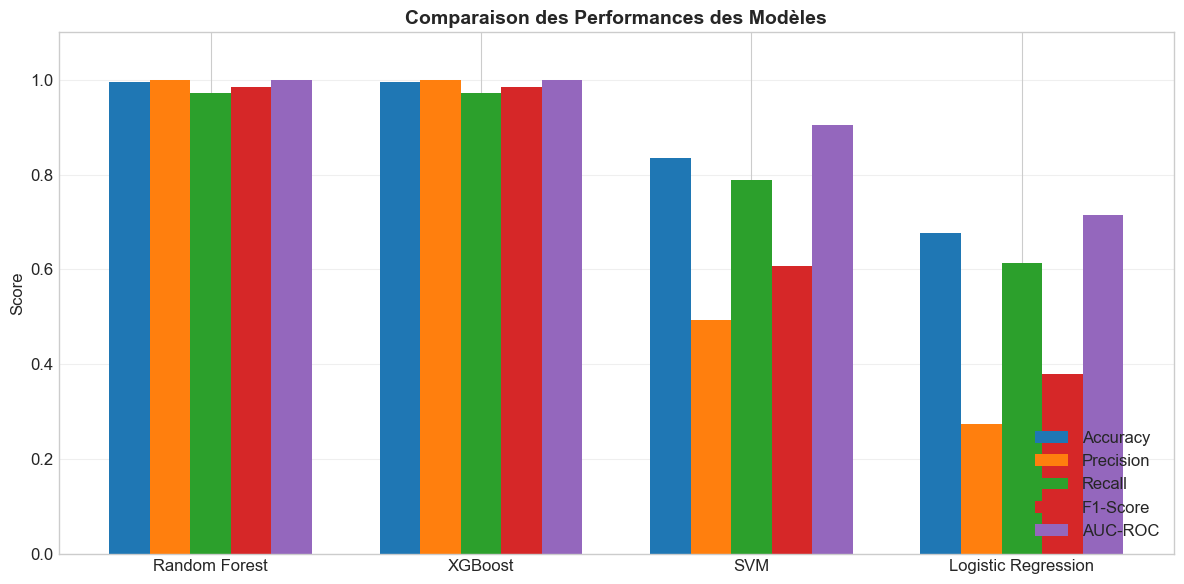

In [24]:
if DATA_READY:
    # Graphique de comparaison
    fig, ax = plt.subplots(figsize=(12, 6))
    
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    x = np.arange(len(results_df))
    width = 0.15
    
    for i, metric in enumerate(metrics_to_plot):
        offset = (i - len(metrics_to_plot)/2 + 0.5) * width
        bars = ax.bar(x + offset, results_df[metric], width, label=metric)
    
    ax.set_ylabel('Score')
    ax.set_title('Comparaison des Performances des Modèles', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df.index)
    ax.legend(loc='lower right')
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Courbes ROC

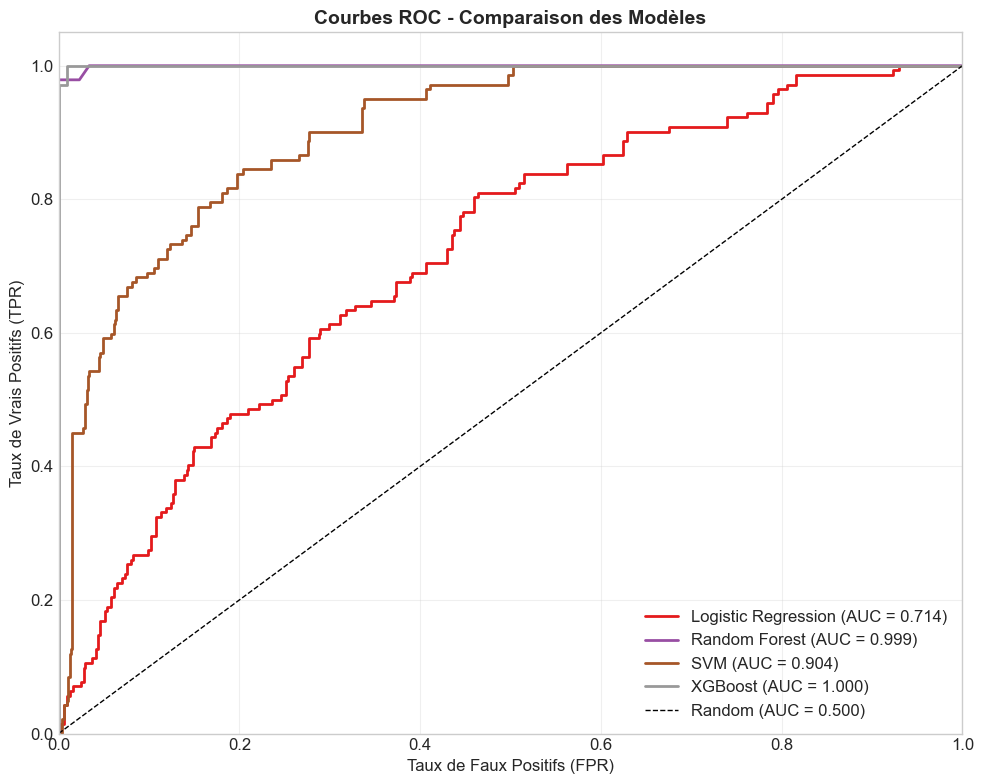

In [25]:
if DATA_READY:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = plt.cm.Set1(np.linspace(0, 1, len(trained_models)))
    
    for (name, model), color in zip(trained_models.items(), colors):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.500)')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Taux de Faux Positifs (FPR)')
    ax.set_ylabel('Taux de Vrais Positifs (TPR)')
    ax.set_title('Courbes ROC - Comparaison des Modèles', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Matrices de Confusion

🏆 Meilleur modèle: Random Forest


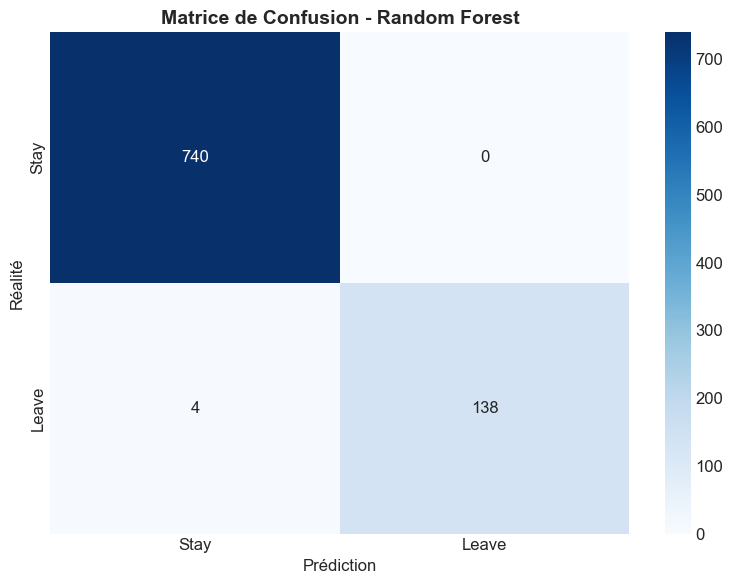


📋 Rapport de Classification:
              precision    recall  f1-score   support

        Stay       0.99      1.00      1.00       740
       Leave       1.00      0.97      0.99       142

    accuracy                           1.00       882
   macro avg       1.00      0.99      0.99       882
weighted avg       1.00      1.00      1.00       882



In [26]:
if DATA_READY:
    # Sélectionner le meilleur modèle
    best_model_name = results_df['F1-Score'].idxmax()
    best_model = trained_models[best_model_name]
    
    print(f" Meilleur modèle: {best_model_name}")
    
    # Matrice de confusion pour le meilleur modèle
    y_pred_best = best_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred_best)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Stay', 'Leave'],
                yticklabels=['Stay', 'Leave'], ax=ax)
    ax.set_title(f'Matrice de Confusion - {best_model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Prédiction')
    ax.set_ylabel('Réalité')
    
    plt.tight_layout()
    plt.show()
    
    # Rapport de classification
    print("\n Rapport de Classification:")
    print(classification_report(y_test, y_pred_best, target_names=['Stay', 'Leave']))

---
## 9. Importance des Features

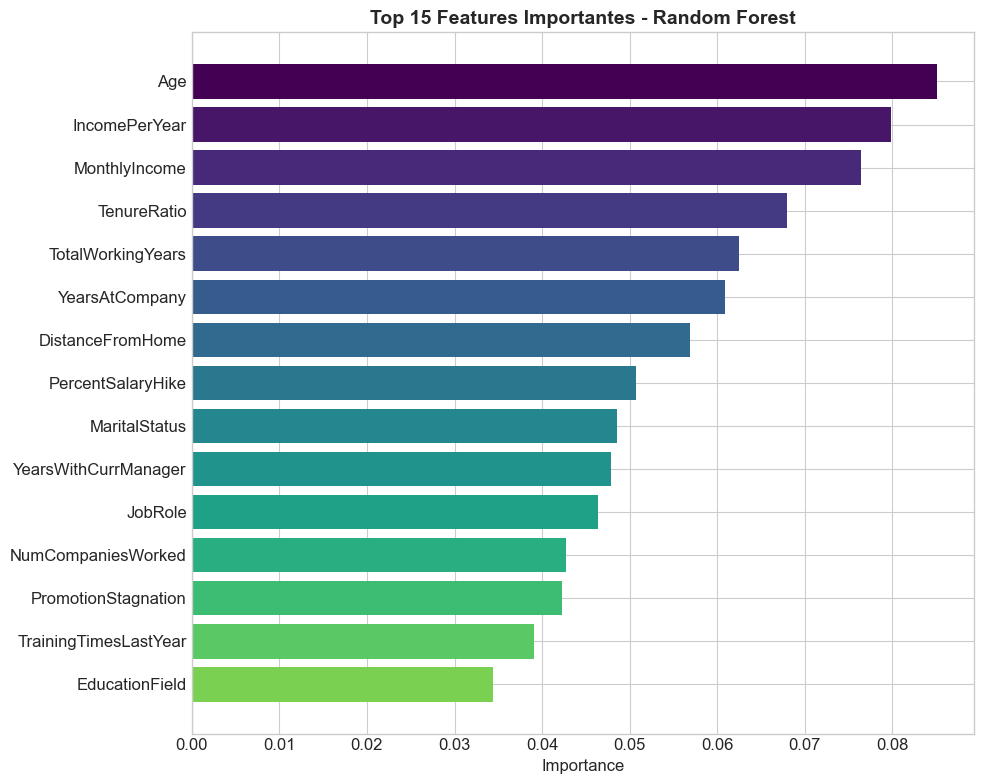


📊 Importance des Features:


,Feature,Importance
0,Age,0.0851
30,IncomePerYear,0.0799
11,MonthlyIncome,0.0764
27,TenureRatio,0.0680
17,TotalWorkingYears,0.0625
19,YearsAtCompany,0.0609
3,DistanceFromHome,0.0569
14,PercentSalaryHike,0.0508
10,MaritalStatus,0.0486
21,YearsWithCurrManager,0.0479


In [27]:
if DATA_READY and 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    
    # Feature importance
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Top 15 features
    top_n = min(15, len(importance_df))
    top_features = importance_df.head(top_n)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = plt.cm.viridis(np.linspace(0, 0.8, top_n))
    ax.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color=colors[::-1])
    
    ax.set_title(f'Top {top_n} Features Importantes - Random Forest', fontsize=14, fontweight='bold')
    ax.set_xlabel('Importance')
    
    plt.tight_layout()
    plt.show()
    
    print("\n Importance des Features:")
    display(importance_df.head(15).round(4))

### Interprétabilité avec SHAP (si disponible)

In [32]:
if DATA_READY and SHAP_AVAILABLE and 'Random Forest' in trained_models:
    print(" Analyse SHAP...")
    
    try:
        # Créer l'explainer
        explainer = shap.TreeExplainer(trained_models['Random Forest'])
        
        # Calculer les valeurs SHAP sur un échantillon
        sample_size = min(100, len(X_test))
        X_sample = X_test.iloc[:sample_size]
        shap_values = explainer.shap_values(X_sample)
        
        # Summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values[1], X_sample, plot_type="bar", max_display=15, show=False)
        plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f" Erreur SHAP: {e}")
elif not SHAP_AVAILABLE:
    print(" SHAP non disponible. Installez avec: pip install shap")

🔍 Analyse SHAP...
⚠️ Erreur SHAP: The shape of the shap_values matrix does not match the shape of the provided data matrix.


<Figure size 1200x800 with 0 Axes>

---
## 10. Benchmarks et Résumé des Performances

In [29]:
if DATA_READY:
    print("=" * 60)
    print("📊 RÉSUMÉ DES BENCHMARKS")
    print("=" * 60)
    
    print("\n📈 Performance des Modèles sur l'ensemble de test:")
    print("-" * 60)
    display(results_df.round(4))
    
    print(f"\n🏆 Meilleur modèle: {best_model_name}")
    print(f"   • F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}")
    print(f"   • AUC-ROC: {results_df.loc[best_model_name, 'AUC-ROC']:.4f}")
    print(f"   • Recall: {results_df.loc[best_model_name, 'Recall']:.4f}")
    
    print("\n📊 Statistiques du Dataset:")
    print("-" * 60)
    print(f"   • Total employés: {len(df)}")
    print(f"   • Train set: {len(X_train)}")
    print(f"   • Test set: {len(X_test)}")
    print(f"   • Features: {len(X.columns)}")
    print(f"   • Taux d'attrition global: {y.mean()*100:.1f}%")

📊 RÉSUMÉ DES BENCHMARKS

📈 Performance des Modèles sur l'ensemble de test:
------------------------------------------------------------


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Model,,,,,
Random Forest,0.9955,1.0000,0.9718,0.9857,0.9994
XGBoost,0.9955,1.0000,0.9718,0.9857,0.9997
SVM,0.8356,0.4934,0.7887,0.6070,0.9040
Logistic Regression,0.6769,0.2744,0.6127,0.3791,0.7142



🏆 Meilleur modèle: Random Forest
   • F1-Score: 0.9857
   • AUC-ROC: 0.9994
   • Recall: 0.9718

📊 Statistiques du Dataset:
------------------------------------------------------------
   • Total employés: 4410
   • Train set: 3528
   • Test set: 882
   • Features: 31
   • Taux d'attrition global: 16.1%


---
## 11. Conclusions et Recommandations

### Résumé des Résultats

Cette analyse du taux d'attrition des employés de HumanForYou a permis d'identifier plusieurs enseignements clés :

#### Facteurs d'Attrition Identifiés

Les principaux facteurs influençant l'attrition des employés sont (basés sur l'importance des features) :

1. **Satisfaction au travail** - Un faible niveau de satisfaction est fortement corrélé au départ
2. **Équilibre vie professionnelle/personnelle** - Les employés insatisfaits de cet équilibre sont plus susceptibles de partir
3. **Ancienneté dans l'entreprise** - Les employés avec peu d'ancienneté présentent un risque plus élevé
4. **Revenu mensuel** - Une rémunération inférieure augmente le risque d'attrition
5. **Distance du domicile** - Les longs trajets sont un facteur de risque

### Recommandations pour HumanForYou

#### Actions à Court Terme
- 🎯 **Programme de rétention ciblé** pour les employés identifiés à risque
- 💬 **Entretiens de rétention** réguliers avec les managers
- 💰 **Révision salariale** pour les postes à forte attrition

#### Actions à Moyen Terme
- 📈 **Plans de carrière personnalisés** pour améliorer la satisfaction
- 🏠 **Politique de télétravail** pour réduire l'impact des trajets
- 🎓 **Programmes de formation** pour développer l'engagement

#### Actions à Long Terme
- 🔄 **Système de monitoring** pour suivre les indicateurs d'attrition en temps réel
- 🏢 **Culture d'entreprise** axée sur le bien-être et l'équilibre
- 📊 **Tableaux de bord RH** pour anticiper les départs

### Limites de l'Analyse

- Les modèles sont entraînés sur des données historiques et peuvent ne pas capturer tous les facteurs d'attrition
- Certaines variables qualitatives (satisfaction, performance) sont subjectives
- Le déséquilibre des classes (15% d'attrition) peut affecter les prédictions
- Les données de badgeage n'ont pas été intégrées dans cette version

### Prochaines Étapes

1. **Intégrer les données de badgeage** pour enrichir les features
2. **Affiner le modèle** avec un tuning des hyperparamètres plus poussé
3. **Déployer le modèle** en production pour des prédictions en temps réel
4. **Mettre en place un monitoring** de la performance du modèle
5. **Former les équipes RH** à l'interprétation des résultats

In [30]:
print("\n" + "=" * 60)
print("✅ ANALYSE TERMINÉE")
print("=" * 60)
print("\n📁 Livrables disponibles:")
print("  • livrables/01_ethique.md - Document éthique")
print("  • livrables/02_bibliographie.md - Bibliographie")
print("  • livrables/03_presentation_notebook.ipynb - Ce notebook")
print("\n💻 Code source:")
print("  • src/data_loader.py - Chargement des données")
print("  • src/data_preprocessing.py - Prétraitement")
print("  • src/feature_engineering.py - Feature engineering")
print("  • src/models.py - Modèles ML")
print("  • src/visualization.py - Visualisations")
print("\n🔗 Pour toute question: consultez le README.md")


✅ ANALYSE TERMINÉE

📁 Livrables disponibles:
  • livrables/01_ethique.md - Document éthique
  • livrables/02_bibliographie.md - Bibliographie
  • livrables/03_presentation_notebook.ipynb - Ce notebook

💻 Code source:
  • src/data_loader.py - Chargement des données
  • src/data_preprocessing.py - Prétraitement
  • src/feature_engineering.py - Feature engineering
  • src/models.py - Modèles ML
  • src/visualization.py - Visualisations

🔗 Pour toute question: consultez le README.md
